# Library

In [40]:
#library
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import scipy
from scipy.integrate import solve_ivp
from scipy.stats import ttest_ind
from scipy.stats import ttest_rel
from sklearn.decomposition import PCA
from scipy.stats import mannwhitneyu
from sklearn.linear_model import LinearRegression

np.random.seed(123)  # For reproducibility

# Parameters


In [2]:
'''
PARAMETERS
'''

#define parameters
n_species = 4
n_cs = 10 # cs = carbon sources

#default values
g = np.ones(n_species) # conversion factor from energy uptake to growth rate, for species i ## all 1's, so all the energy is converted into growth ?
m = np.zeros(n_species) # minimal energy uptake for maintenance of species (energy/time)
l = 0.1*np.ones((n_species, n_cs)) # leakage fractions for resource 'a' (unitless)
K = 1e-1*np.ones(n_cs) # consider making this small (affinity)
w = np.ones(n_cs) # all metabolites have the same energy
d = 0.1 # dilution rate
c =  np.ones((n_species,n_cs)) #MAX uptake of a ressource a by a species i
J = np.zeros((n_species, n_cs)) #energie intake d'in individu i par une ressource a
D = np.full((n_species, n_cs, n_cs),0.05) #matrice du by product d'une ressource b produit par un individu i consommant une ressource a

print(c)

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


In [3]:
N0 = [ # list of initial population densities
    1e-4, # species 1
    1e-4, # species 2
    1e-4, # species 3
    1e-4  # species 4
    ]
R0 = np.zeros(n_cs) # concentration of resources at t=0 (mass/volume)
R0[0] = 10 # first resource has a concentration of 10 (why ?) parce que après on va peut être obtenir les autres ressources grace aux byproduct
y0 = np.append(np.array(N0),R0)

In [44]:
'''
DETAILED AND RANDOMIZED PARAMETERS
- w = 1, m = 0, l=0, d=0
'''

# INITAL POPULATION
n_species = 3
N0 = np.array([1e-1, 1e-2, 5e-2]) # species 1,2,3

# INITAL RESOURCES
n_cs = 3 # cs = carbon sources
R0 = np.array([10, 20, 15]) # resources 1,2,3

# INITIAL STATE
y0 = np.append(np.array(N0),R0)

# ----------------------------
'''
# CONVERSION FACTOR from energy to growth rate (DETAILED)
g = np.ones(n_species)
g = np.array([0.25, 0.5, 0.5]) # for species 1,2,3
'''

# CONVERSION FACTOR from energy to growth rate (RANDOM)
g = np.ones(n_species)
for i in range(n_species):
    g[i] = np.random.rand()

# ----------------------------
# AFFINITY of each resource
K = np.ones(n_cs)
K = np.array([0.01, 0.02, 0.01]) # for resource 1,2,3

# ----------------------------
'''
# MAX UPTAKE of a resource a by a species i (DETAILED)
c =  np.ones((n_species,n_cs)) # MAX UPTAKE of a ressource a by a species i
c = np.array([[0.8, 0.5, 1.0],  # species 1, resource 1,2,3
              [1.0, 0.8, 0.5],  # species 2, resource 1,2,3
              [0.5, 1.0, 0.8]]) # species 3, resource 1,2,3
'''

# MAX UPTAKE of a resource a by a species i (RANDOM)
for i in range(n_species) :
  for j in range(n_cs):
    c[i, j] = np.random.rand()  # Randomize c for each species and resource

# ----------------------------
# BYPRODUCT produced by species a from resource i (RANDOM)
D = np.zeros((n_species, n_cs, n_cs))
for i in range(n_species):
    for b in range(n_cs):
        random_values = np.random.rand(n_cs)
        normalized_values = random_values / np.sum(random_values)  # Normalize to ensure the sum is 1
        D[i, :, b] = normalized_values * np.random.rand()  # Randomize the scaling to ensure the sum is less than 1

'''
# BYPRODUCT produced by species a from resource i (DETAILED)
D = np.zeros((n_species, n_cs, n_cs))

# Production by species 1
D[0] = [
    [0.05, 0, 0],   # byproduct 1 from resources 1, 2, 3
    [0, 0.075, 0],  # byproduct 2 from resources 1, 2, 3
    [0, 0, 0.1]     # byproduct 3 from resources 1, 2, 3
]
# Production by species 2
D[1] = [
    [0.125, 0, 0],  # byproduct 1 from resources 1, 2, 3
    [0, 0.15, 0],   # byproduct 2 from resources 1, 2, 3
    [0, 0, 0.175]   # byproduct 3 from resources 1, 2, 3
]
# Production by species 3
D[2] = [
    [0.2, 0, 0],    # byproduct 1 from resources 1, 2, 3
    [0, 0.225, 0],  # byproduct 2 from resources 1, 2, 3
    [0, 0, 0.25]    # byproduct 3 from resources 1, 2, 3
]
'''

# ----------------------------
# DILUTION RATE (=decay)
d = 0.1

# Complete model


In [5]:
'''
MODEL 1 : CR_model
'''

# complete model
def CR_model(t, y, c, K, w, l, m, g, d, D):

  N = y[:n_species]
  R = y[n_species:]
  R[R<0] = 0 #no negative values
  N[N<1e-6] = 0 #no negative values
  J = np.zeros((n_species, n_cs)) # uptake of resource i by species a
  for i in range(n_species): # for every resource
    for a in range(n_cs): # for every species
      J[i,a] = c[i,a]*R[a]/(R[a]+K[a]) # uptake ~ max uptake, resource concentration, affinity

  dNdt = np.zeros(n_species) # variation in population ~ resource uptake
  for i in range(n_species): # for every species
    growth_intake = np.sum([(J[i, a]*w[a]*(1-l[i,a]))-m[i]for a in range(n_cs)]) # growth ~ uptake, energy content of resource, leakage, maintenance
                                                                                 # -> sum of every resource
    dNdt[i] = g[i]*N[i]*growth_intake-(N[i]*d) # population evolution ~ conversion rate, population, growth intake, dilution rate

  dRdt = np.zeros(n_cs) # variation in resource ~ consumption and byproduct production
  for a in range(n_cs): # for every resource
    consumption = np.sum([N[i]*J[i,a] for i in range(n_species)]) # consumption ~ population, resource uptake
                                                                  # -> sum for every species
    byproduction_tot = np.zeros((n_species, n_cs)) # byproduct production
    for i in range(n_species): # for every species
      for b in range(n_cs): # for every resource
        byproduction_tot[i,b] = D[i,a,b]*w[b]*l[i,b]*N[i]*J[i,b]/w[a] # production ~ fraction converted, energy content, leakage, population, uptake
    byproduction = np.sum(byproduction_tot) # add all byproduct production FOR ONE RESOURCE (see [24])
    dRdt[a] = (R0[a]-R[a])*d - consumption + byproduction # resource evolution ~ dilution, consumption, byproduct production

  return np.concatenate((dNdt,dRdt))

In [6]:
t_span = (0,100)
t_eval = np.linspace(t_span[0], t_span[1],300)

In [7]:
#solution of the model
c[0,0] = 0.5
c[1,0] = 0.75
c[2,0] = 0
c[3,1] = 0
c[1,1] = 0
c[2,1] = 0.2
c[0,1] = 0.2
c[0,2] = 0.1
c[1,2] = 0
c[2,2] = 0.6
c[3,2] = 0
c[0,3] = 0
c[1,3] = 0.2
c[2,3] = 0
c[3,3] = 0
print(c)

solutions = solve_ivp(CR_model, t_span, y0, args=(c, K, w, l, m, g, d, D), method = "BDF")

[[0.5  0.2  0.1  0.   1.   1.   1.   1.   1.   1.  ]
 [0.75 0.   0.   0.2  1.   1.   1.   1.   1.   1.  ]
 [0.   0.2  0.6  0.   1.   1.   1.   1.   1.   1.  ]
 [1.   0.   0.   0.   1.   1.   1.   1.   1.   1.  ]]


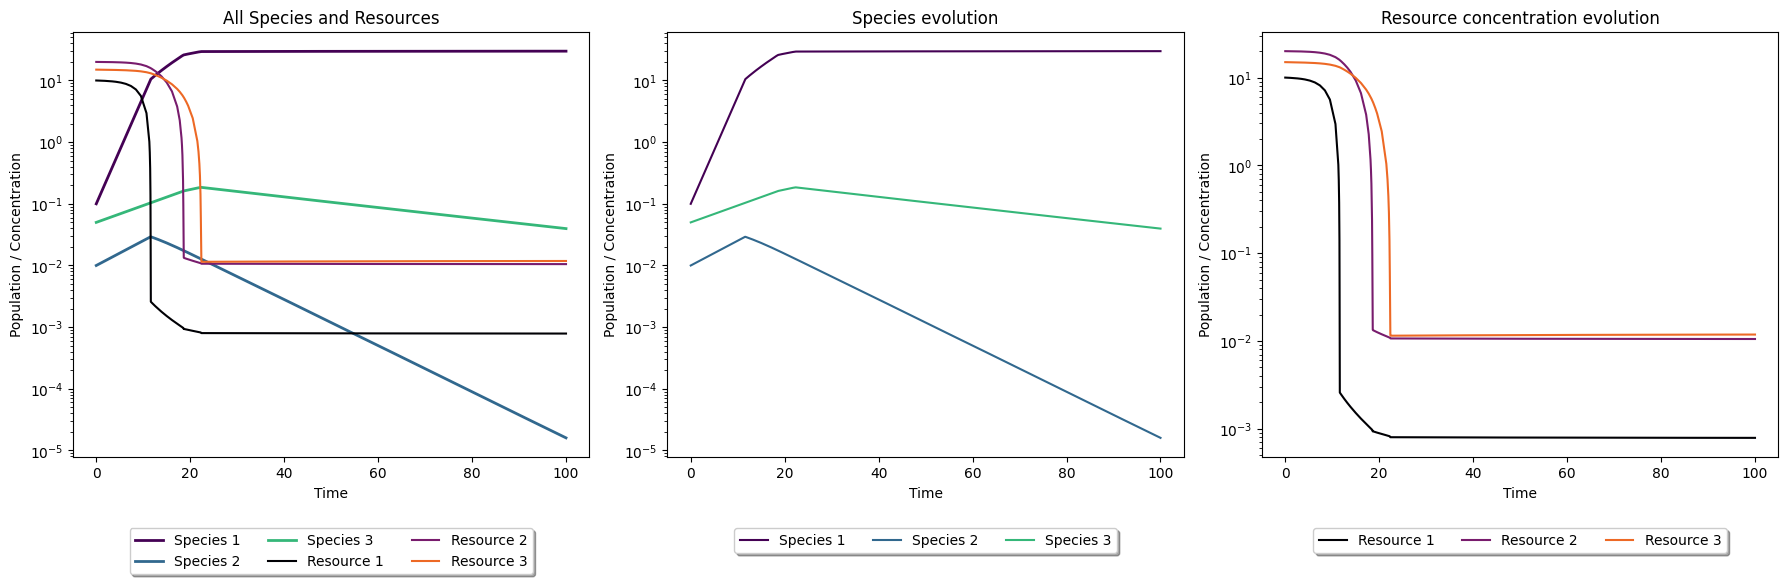

In [8]:
# better plot for solutions ?

legend_species = [f"Species {i}" for i in range(1, n_species+1)]
legend_cs = [f"Resource {i}" for i in range (1, n_cs+1)]

cmap_species = cm.viridis
colors_species = [cmap_species(i / n_species) for i in range(n_species)]

cmap_cs = cm.inferno
colors_cs = [cmap_cs(i / n_cs) for i in range(n_cs)]


fig, axs = plt.subplots(1,3, figsize=(18, 6))

# Premier graphique avec tout
for i in range(n_species):
    axs[0].plot(solutions.t,
                solutions.y[i],
                label=legend_species[i],
                color=colors_species[i],
                linewidth=2.0)
for i in range(n_cs):
    axs[0].plot(solutions.t,
                solutions.y[i+n_species],
                label=legend_cs[i],
                color=colors_cs[i])
axs[0].set_yscale('log')
axs[0].set_title('All Species and Resources')

# Deuxième graphique avec seulement les espèces
for i in range(n_species):
    axs[1].plot(solutions.t,
                solutions.y[i],
                label=legend_species[i],
                color=colors_species[i])
axs[1].set_yscale('log')
axs[1].set_title('Species evolution')

# Troisième graphique avec seulement les cs
for i in range(n_cs):
    axs[2].plot(solutions.t,
                solutions.y[i+n_species],
                label=legend_cs[i],
                color=colors_cs[i])
axs[2].set_yscale('log')
axs[2].set_title('Resource concentration evolution')

# Titres et légendes
for ax in axs:
    ax.set_xlabel('Time')
    ax.set_ylabel('Population / Concentration')
    ax.legend(loc='upper center',
              bbox_to_anchor=(0.5, -0.15),
              fancybox=True,
              shadow=True,
              ncol=3)

plt.tight_layout()
plt.show()

In [9]:
#Randomisation of some parameters
#c = np.random.uniform(low = 0, high = 1,size = (n_species,n_cs))
D = np.random.uniform(low = 0, high = 0.1,size=(n_species, n_cs, n_cs)) #matrice du by product d'une ressource b produit par un individu i consommant une ressource a)


In [10]:
t_span = (0,10000)
t_eval = np.linspace(t_span[0], t_span[1],300)
solutions2 = solve_ivp(CR_model, t_span, y0,args=(c, K, w, l, m, g, d, D), method = "BDF")

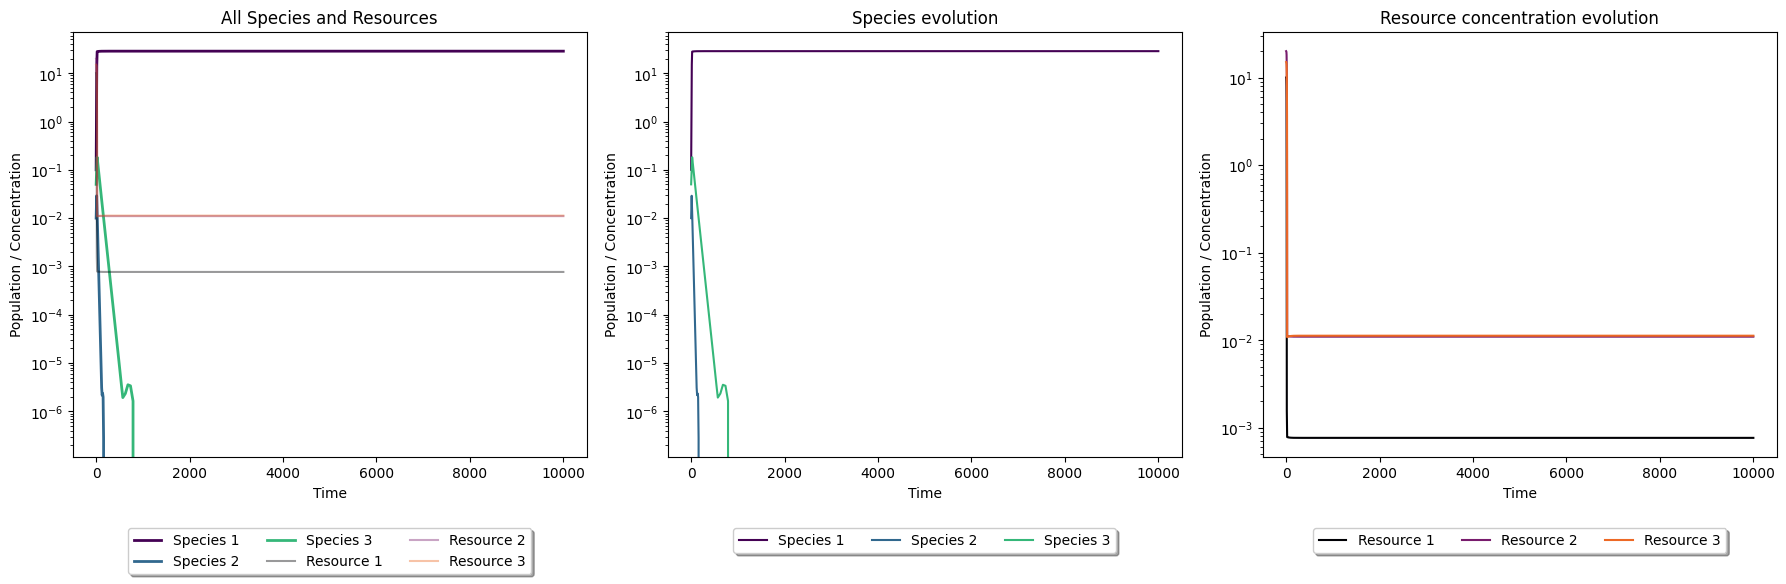

In [11]:
# better plot for solutions *2* ?

legend_species = [f"Species {i}" for i in range(1, n_species+1)]
legend_cs = [f"Resource {i}" for i in range (1, n_cs+1)]

cmap_species = cm.viridis
colors_species = [cmap_species(i / n_species) for i in range(n_species)]

cmap_cs = cm.inferno
colors_cs = [cmap_cs(i / n_cs) for i in range(n_cs)]


fig, axs = plt.subplots(1,3, figsize=(18, 6))

# Premier graphique avec tout
for i in range(n_species):
    axs[0].plot(solutions2.t,
                solutions2.y[i],
                label=legend_species[i],
                color=colors_species[i],
                linewidth=2.0)
for i in range(n_cs):
    axs[0].plot(solutions2.t,
                solutions2.y[i+n_species],
                label=legend_cs[i],
                color=colors_cs[i],
                alpha = 0.4)
axs[0].set_yscale('log')
axs[0].set_title('All Species and Resources')

# Deuxième graphique avec seulement les espèces
for i in range(n_species):
    axs[1].plot(solutions2.t,
                solutions2.y[i],
                label=legend_species[i],
                color=colors_species[i])
axs[1].set_yscale('log')
axs[1].set_title('Species evolution')

# Troisième graphique avec seulement les cs
for i in range(n_cs):
    axs[2].plot(solutions2.t,
                solutions2.y[i+n_species],
                label=legend_cs[i],
                color=colors_cs[i])
axs[2].set_yscale('log')
axs[2].set_title('Resource concentration evolution')

# Titres et légendes
for ax in axs:
    ax.set_xlabel('Time')
    ax.set_ylabel('Population / Concentration')
    ax.legend(loc='upper center',
              bbox_to_anchor=(0.5, -0.15),
              fancybox=True,
              shadow=True,
              ncol=3)

plt.tight_layout()
plt.show()

In [12]:
#random multiple simulations
t_span = (0,100000)
t_eval = np.linspace(t_span[0], t_span[1],300)
sim_dict = {}
for i in range(20):
  c = np.random.uniform(low = 0, high = 1,size = (n_species,n_cs))
  D = np.random.uniform(low = 0, high = 0.1,size=(n_species, n_cs, n_cs))
  sol = solve_ivp(CR_model, t_span, y0,args=(c, K, w, l, m, g, d, D), method = "BDF")
  sim_dict[f"simulation {i}"] = [[c,D],sol]


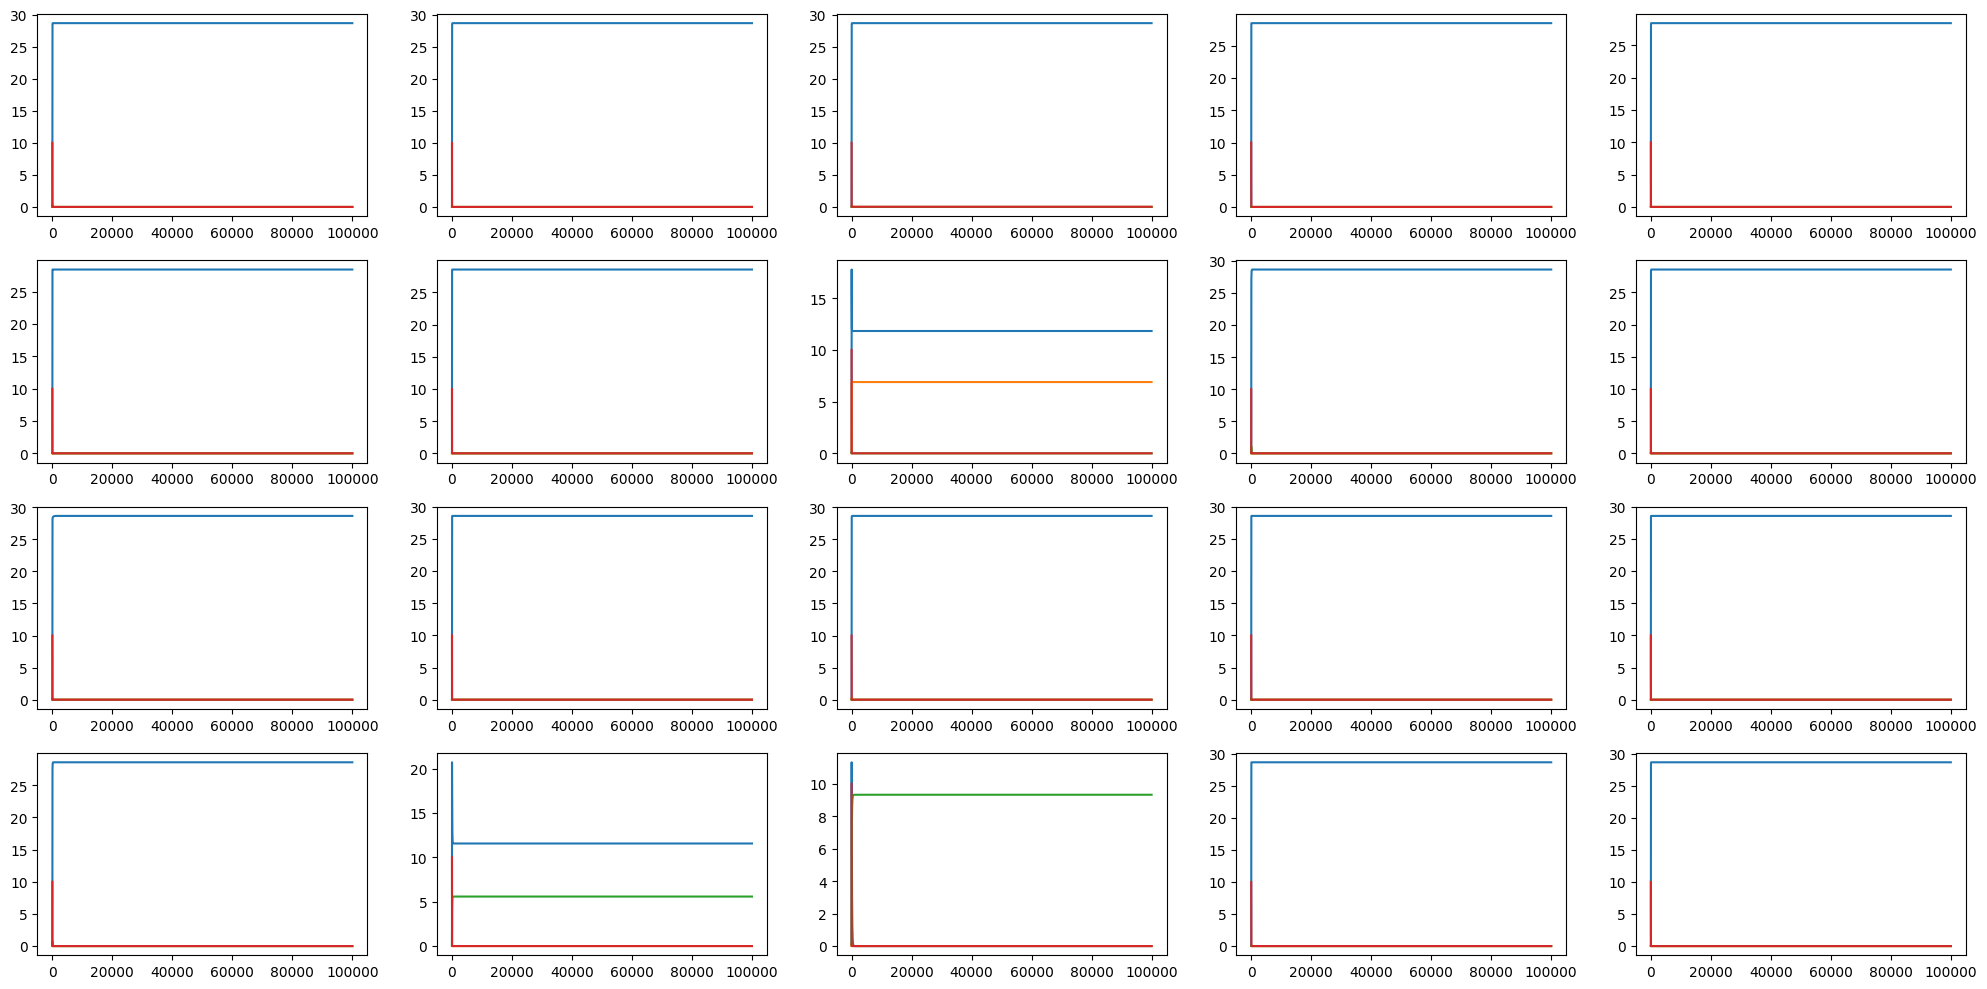

In [13]:
#plotting usinage
#trash

fig, axs = plt.subplots(4,5,figsize = (20,10))

for ax, key, value in zip(axs.ravel(), sim_dict.keys(), sim_dict.values()):
  ax.plot(value[1].t, value[1].y[0], label='Species 1')
  ax.plot(value[1].t, value[1].y[1], label='Species 2')
  ax.plot(value[1].t, value[1].y[2], label='Species 3')
  ax.plot(value[1].t, value[1].y[3], label='Species 4')  #ax.set_yscale("log")
plt.tight_layout()
plt.show()


# Simple model

In [14]:
# MODEL
def CR_model_simple(t,y) :

  N = y[:n_species]
  R = y[n_species:]
  R[R<0] = 0 #no negative values
  N[N<1e-6] = 0 #no negative values

  # resource uptake
  J = np.zeros((n_species, n_cs)) # uptake of resource i by species a
  for i in range(n_species): # for every resource
    for a in range(n_cs): # for every species
      J[i, a] = c[i, a] * R[a] / (R[a] + K[a]) # uptake ~ max uptake, resource concentration, affinity

 # population variation
  dNdt = np.zeros(n_species) # variation in population ~ resource uptake
  for i in range(n_species): # for every species
    growth_intake = np.sum(J[i, :]) # growth ~ uptake, energy content of resource // NO LEAKAGE, NO MAINTENANCE                                                                             # -> for every resource, added up
    dNdt[i] = g[i]*N[i]*growth_intake-(N[i]*d) # population evolution ~ conversion rate, population, growth intake // with dilution (else population will never decrease and we won't be able to determine in wich case it doesn't)

  # resource variation
  dRdt = np.zeros(n_cs) # variation in resource ~ consumption and byproduct production
  for a in range(n_cs): # for every resource
    consumption = np.sum([N[i]*J[i,a] for i in range(n_species)]) # consumption ~ population, resource uptake

    # byproduct formation                                                                 # -> sum for every species
    byproduction_tot = np.zeros((n_species, n_cs)) # byproduct production
    for i in range(n_species): # for every species
      for b in range(n_cs): # for every resource
        byproduction_tot[i, b] = D[i, a, b] * N[i] * J[i, b] # production ~ fraction converted, energy content, population, uptake // NO LEAKAGE, NO VAR IN RESOURCE ENERGY CONTENT
    byproduction = np.sum(byproduction_tot[:, a]) # add all byproduct production FOR ONE RESOURCE (see [24])
    dRdt[a] = (R0[a]-R[a]) - consumption + byproduction # resource evolution ~ consumption, byproduct production // NO DILUTION

  return np.concatenate((dNdt,dRdt))

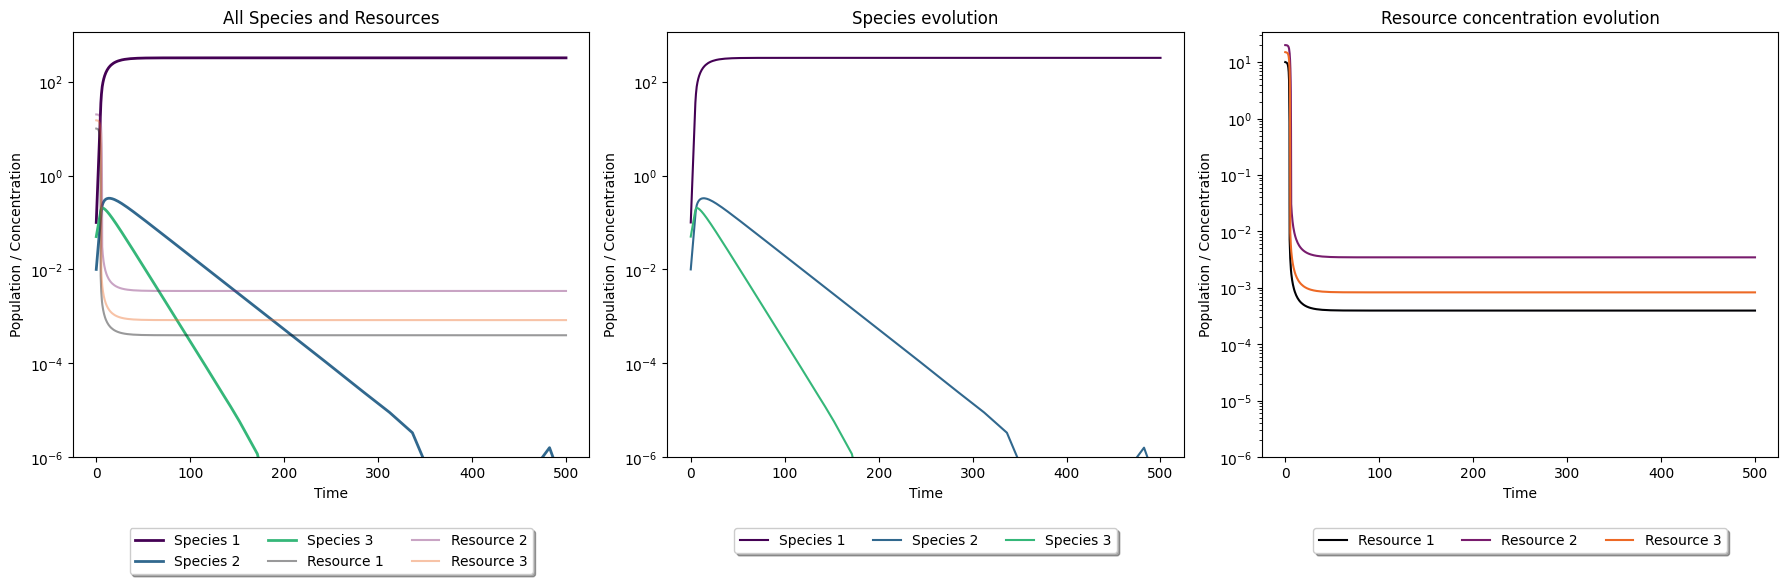

In [15]:
# DEFINE TIMEFRAME, SEARCH SOLUTIONS
t_span = (0,500)
solutions_simple = solve_ivp(CR_model_simple, t_span, y0, method = "BDF")


# PLOT SOLUTIONS
legend_species = [f"Species {i}" for i in range(1, n_species+1)]
legend_cs = [f"Resource {i}" for i in range (1, n_cs+1)]

cmap_species = cm.viridis
colors_species = [cmap_species(i / n_species) for i in range(n_species)]

cmap_cs = cm.inferno
colors_cs = [cmap_cs(i / n_cs) for i in range(n_cs)]


fig, axs = plt.subplots(1,3, figsize=(18, 6))

# Premier graphique avec tout
for i in range(n_species):
    axs[0].plot(solutions_simple.t,
                solutions_simple.y[i],
                label=legend_species[i],
                color=colors_species[i],
                linewidth=2.0)
for i in range(n_cs):
    axs[0].plot(solutions_simple.t,
                solutions_simple.y[i+n_species],
                label=legend_cs[i],
                color=colors_cs[i],
                alpha = 0.4)
axs[0].set_yscale('log')
axs[0].set_title('All Species and Resources')

# Deuxième graphique avec seulement les espèces
for i in range(n_species):
    axs[1].plot(solutions_simple.t,
                solutions_simple.y[i],
                label=legend_species[i],
                color=colors_species[i])
axs[1].set_yscale('log')
axs[1].set_title('Species evolution')

# Troisième graphique avec seulement les cs
for i in range(n_cs):
    axs[2].plot(solutions_simple.t,
                solutions_simple.y[i+n_species],
                label=legend_cs[i],
                color=colors_cs[i])
axs[2].set_yscale('log')
axs[2].set_title('Resource concentration evolution')

# Titres et légendes
for ax in axs:
    ax.set_xlabel('Time')
    ax.set_ylabel('Population / Concentration')
    ax.legend(loc='upper center',
              bbox_to_anchor=(0.5, -0.15),
              fancybox=True,
              shadow=True,
              ncol=3)
    ax.set_ylim(bottom=1e-6) # anything below is considered absent


plt.tight_layout()
plt.show()
f2 = solutions_simple.y[1][-1:]
f3 = solutions_simple.y[2][-1:]

# Interactive plots

In [19]:
'''
TEST plotly
'''

# Résolution du modèle
t_span = (0, 1000)
solution = solve_ivp(
    lambda t, y: CR_model_simple(t, y,),
    t_span,
    y0,
    method = 'BDF'
)

def inter_plot(sollution):
  # Création des graphiques avec Plotly
  fig = go.Figure()

  # Premier graphique avec toutes les espèces et ressources
  for i in range(n_species):
      fig.add_trace(go.Scatter(x=solution.t,
                              y=solution.y[i],
                              mode='lines',
                              name=f'Species {i+1}'))
  for i in range(n_cs):
      fig.add_trace(go.Scatter(x=solution.t,
                              y=solution.y[i+n_species],
                              mode='lines',
                              name=f'Resource {i+1}',
                              line=dict(dash='dash')))
  fig.update_layout(title='All Species and Resources',
                    xaxis_title='Time',
                    yaxis_title='Population / Concentration',
                    yaxis_type='log')

  # Deuxième graphique avec seulement les espèces
  fig2 = go.Figure()
  for i in range(n_species):
      fig2.add_trace(go.Scatter(x=solution.t,
                                y=solution.y[i],
                                mode='lines',
                                name=f'Species {i+1}'))
  fig2.update_layout(title='Species evolution',
                    xaxis_title='Time',
                    yaxis_title='Population',
                    yaxis_type='log')

  # Troisième graphique avec seulement les ressources
  fig3 = go.Figure()
  for i in range(n_cs):
      fig3.add_trace(go.Scatter(x=solution.t,
                                y=solution.y[i+n_species],
                                mode='lines',
                                name=f'Resource {i+1}',
                                line=dict(dash='dash')))
  fig3.update_layout(title='Resource concentration evolution',
                    xaxis_title='Time',
                    yaxis_title='Concentration',
                    yaxis_type='log')

  # Affichage des graphiques
  fig.show()
  fig2.show()
  fig3.show()
inter_plot(solution)

# Trash ??

In [ ]:
'''
Cohabitation possible when g*growth_intake is equivalent between species
'''

# Randomisation et comparage de l'égalité g*growth intake

## For alive ones against each other

In [59]:
t_span = (0,10000)
t_eval = np.linspace(t_span[0], t_span[1],300)
sim_dict = {}
for j in range(200):
  c = np.random.uniform(low = 0, high = 1,size = (n_species,n_cs))
  D = np.zeros((n_species, n_cs, n_cs))
  for i in range(n_species):
    for b in range(n_cs):
        random_values = np.random.rand(n_cs)
        normalized_values = random_values / np.sum(random_values)  # Normalize to ensure the sum is 1
        D[i, :, b] = normalized_values * np.random.rand()
  g = np.random.uniform(low = 0, high = 1, size = (n_species))
  sol = solve_ivp(CR_model_simple, t_span, y0, method = "BDF")
  sim_dict[f"simulation {j}"] = [[g,c,D],sol]

[[array([0.36471408, 0.41925967, 0.1384293 ]),
  array([[0.54788181, 0.61628478, 0.08669972],
         [0.1451873 , 0.79098432, 0.79830309],
         [0.51190104, 0.92307694, 0.70348111]]),
  array([[[0.21250163, 0.12744399, 0.07653798],
          [0.29743782, 0.12190093, 0.33288051],
          [0.15026495, 0.14098157, 0.49858917]],
  
         [[0.31656268, 0.00510578, 0.00421235],
          [0.11174954, 0.01083203, 0.08415863],
          [0.35239057, 0.00118461, 0.12969996]],
  
         [[0.04108997, 0.07788862, 0.0676946 ],
          [0.01045305, 0.04021296, 0.22382347],
          [0.04977416, 0.11561607, 0.07220103]]])],
   message: The solver successfully reached the end of the integration interval.
   success: True
    status: 0
         t: [ 0.000e+00  5.929e-03 ...  5.337e+03  1.000e+04]
         y: [[ 1.000e-01  1.002e-01 ...  2.412e+01  2.412e+01]
             [ 1.000e-02  1.004e-02 ...  1.890e+02  1.890e+02]
             ...
             [ 2.000e+01  2.000e+01 ...  2.838e-0

In [66]:

cohabitation_data = {"sim":[],"g" : [], "c" :[], "D" : [], "alive" : [], "dead" : []}

domination_data = {"sim":[],"g" : [], "c":[], "D":[], "alive" : [], "dead" : []}

for i in range(len(sim_dict)):
  index_alive = []
  index_dead = []
  for a in range(n_species):
    if sim_dict[f"simulation {i}"][1].y[a][-1:] > 1e-9:
      index_alive.append(a)
    else:
      index_dead.append(a)
  if len(index_alive) > 1:
    cohabitation_data["sim"].append(f"simulation {i}")
    cohabitation_data["g"].append(sim_dict[f"simulation {i}"][0][0])
    cohabitation_data["c"].append(sim_dict[f"simulation {i}"][0][1])
    cohabitation_data["D"].append(sim_dict[f"simulation {i}"][0][2])
    cohabitation_data["alive"].append(index_alive)
    cohabitation_data["dead"].append(index_dead)

  else:
    domination_data["sim"].append(f"simulation {i}")
    domination_data["g"].append(sim_dict[f"simulation {i}"][0][0])
    domination_data["c"].append(sim_dict[f"simulation {i}"][0][1])
    domination_data["D"].append(sim_dict[f"simulation {i}"][0][2])
    domination_data["alive"].append(index_alive)
    domination_data["dead"].append(index_dead)
cohabitation_df = pd.DataFrame(cohabitation_data)
domination_df = pd.DataFrame(domination_data)
cohabitation_df.head()


,sim,g,c,D,alive,dead
0,simulation 0,"[0.3647140774465578, 0.41925966767118095, 0.13...","[[0.547881811904455, 0.616284781520652, 0.0866...","[[[0.21250163393000013, 0.12744399309108265, 0...","[0, 1]",[2]
1,simulation 3,"[0.6596893452485327, 0.21676348637738008, 0.80...","[[0.8306997472977073, 0.28275668252584096, 0.9...","[[[0.14443397839341537, 0.12115690127139754, 0...","[0, 2]",[1]
2,simulation 9,"[0.6734761179569584, 0.7750696917642756, 0.218...","[[0.11243086993134876, 0.813745451493369, 0.08...","[[[0.2770516949515392, 0.11393610646841708, 0....","[0, 1]",[2]
3,simulation 11,"[0.8197614519030428, 0.7379456700330629, 0.692...","[[0.21861680873160005, 0.07773740212975322, 0....","[[[0.25706100911573915, 0.22840732900943073, 0...","[1, 2]",[0]
4,simulation 16,"[0.7881968482337117, 0.5419555943030311, 0.906...","[[0.7259161891120915, 0.2558365463996257, 0.40...","[[[0.1926924380478935, 0.31658667802586954, 0....","[1, 2]",[0]


In [69]:
# Statistical analysis
#trash

J_index = []
for j in range(len(cohabitation_df)):

  J_co = np.zeros((len(cohabitation_df["alive"][j]), n_cs))
  for m,i in enumerate(cohabitation_df["alive"][j]):
    for a in range(n_cs):
      J_co[m,a] = cohabitation_df["c"][j][i,a]* sim_dict[cohabitation_df["sim"][j]][1].y[n_species + a][-1:] / (sim_dict[cohabitation_df["sim"][j]][1].y[i][-1:] + K[a])
  J_index.append(J_co)

cohabitation_df["J"] = J_index
cohabitation_df.head()


<ipython-input-69-872a21888d84>:10: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



,sim,g,c,D,alive,dead,J
0,simulation 0,"[0.3647140774465578, 0.41925966767118095, 0.13...","[[0.547881811904455, 0.616284781520652, 0.0866...","[[[0.21250163393000013, 0.12744399309108265, 0...","[0, 1]",[2],"[[0.00011838789838750574, 7.244125188848267e-0..."
1,simulation 3,"[0.6596893452485327, 0.21676348637738008, 0.80...","[[0.8306997472977073, 0.28275668252584096, 0.9...","[[[0.14443397839341537, 0.12115690127139754, 0...","[0, 2]",[1],"[[4.22219223893755e-06, 4.352807994220125e-06,..."
2,simulation 9,"[0.6734761179569584, 0.7750696917642756, 0.218...","[[0.11243086993134876, 0.813745451493369, 0.08...","[[[0.2770516949515392, 0.11393610646841708, 0....","[0, 1]",[2],"[[1.4291652399792745e-06, 0.000139247675461107..."
3,simulation 11,"[0.8197614519030428, 0.7379456700330629, 0.692...","[[0.21861680873160005, 0.07773740212975322, 0....","[[[0.25706100911573915, 0.22840732900943073, 0...","[1, 2]",[0],"[[3.7020465552177263e-06, 1.795618031429377e-0..."
4,simulation 16,"[0.7881968482337117, 0.5419555943030311, 0.906...","[[0.7259161891120915, 0.2558365463996257, 0.40...","[[[0.1926924380478935, 0.31658667802586954, 0....","[1, 2]",[0],"[[4.669791713883536e-06, 1.112916706788567e-05..."


In [70]:
# calcul de growth_intake pour les espèces survivantes
growth_index = []
for j in range(len(cohabitation_df)):
  ggrowth = []
  for m,i in enumerate(cohabitation_df["alive"][j]):
    ggrowth.append(cohabitation_df["g"][j][i]*np.sum(cohabitation_df["J"][j][m, :]))
  growth_index.append(ggrowth)
cohabitation_df["ggrowth"] = growth_index
cohabitation_df.head()

,sim,g,c,D,alive,dead,J,ggrowth
0,simulation 0,"[0.3647140774465578, 0.41925966767118095, 0.13...","[[0.547881811904455, 0.616284781520652, 0.0866...","[[[0.21250163393000013, 0.12744399309108265, 0...","[0, 1]",[2],"[[0.00011838789838750574, 7.244125188848267e-0...","[7.127265689588151e-05, 8.92170912529211e-06]"
1,simulation 3,"[0.6596893452485327, 0.21676348637738008, 0.80...","[[0.8306997472977073, 0.28275668252584096, 0.9...","[[[0.14443397839341537, 0.12115690127139754, 0...","[0, 2]",[1],"[[4.22219223893755e-06, 4.352807994220125e-06,...","[9.298021227734856e-06, 6.348605800018452e-06]"
2,simulation 9,"[0.6734761179569584, 0.7750696917642756, 0.218...","[[0.11243086993134876, 0.813745451493369, 0.08...","[[[0.2770516949515392, 0.11393610646841708, 0....","[0, 1]",[2],"[[1.4291652399792745e-06, 0.000139247675461107...","[9.644485075878955e-05, 4.457782934990767e-06]"
3,simulation 11,"[0.8197614519030428, 0.7379456700330629, 0.692...","[[0.21861680873160005, 0.07773740212975322, 0....","[[[0.25706100911573915, 0.22840732900943073, 0...","[1, 2]",[0],"[[3.7020465552177263e-06, 1.795618031429377e-0...","[6.244610351553687e-06, 9.517467215559836e-06]"
4,simulation 16,"[0.7881968482337117, 0.5419555943030311, 0.906...","[[0.7259161891120915, 0.2558365463996257, 0.40...","[[[0.1926924380478935, 0.31658667802586954, 0....","[1, 2]",[0],"[[4.669791713883536e-06, 1.112916706788567e-05...","[1.5066409209945901e-05, 5.950822659933628e-06]"


In [71]:
#application d'un paired ttest
gspecies_x = [i[0] for i in cohabitation_df["ggrowth"]]
gspecies_y = [i[1] for i in cohabitation_df["ggrowth"]]

t_statistic, p_value = ttest_rel(gspecies_x, gspecies_y)
p_value

0.31790019041381584

## for dead ones against each other

In [72]:
J_index = []
for j in range(len(domination_df)):

  J_co = np.zeros((len(domination_df["dead"][j]), n_cs))
  for m,i in enumerate(domination_df["dead"][j]):
    for a in range(n_cs):
      J_co[m,a] = domination_df["c"][j][i,a]* sim_dict[domination_df["sim"][j]][1].y[n_species + a][-1:] / (sim_dict[domination_df["sim"][j]][1].y[i][-1:] + K[a])
  J_index.append(J_co)

domination_df["J"] = J_index
domination_df.head()

<ipython-input-72-34d1393f706a>:7: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



,sim,g,c,D,alive,dead,J,ggrowth
0,simulation 1,"[0.8001244580928546, 0.42326670601735306, 0.09...","[[0.35038006453283843, 0.2596279422739226, 0.7...","[[[0.21991768759547656, 0.04806125590064933, 0...",[0],"[1, 2]","[[0.06371744386189393, 0.1524824067072845, 0.0...","[0.0, 0.0]"
1,simulation 2,"[0.16322588650196634, 0.611214501036071, 0.970...","[[0.9035300799720274, 0.9976081452879686, 0.15...","[[[0.031392923779294056, 0.004098719710886306,...",[2],"[0, 1]","[[0.02602444685836591, 0.18417705085380112, 0....","[0.0, 0.0]"
2,simulation 4,"[0.48736434848770915, 0.4732971930923351, 0.23...","[[0.055386983509193244, 0.8635354509529598, 0....","[[[0.06719406041076707, 0.22377792948558572, 0...",[1],"[0, 2]","[[0.0035817759530271586, 0.11832092150577034, ...","[0.0, 0.0]"
3,simulation 5,"[0.11588165344477763, 0.9280780340785647, 0.45...","[[0.3278364989854916, 0.012311560238901453, 0....","[[[0.21798512240396334, 0.08862708700026639, 0...",[1],"[0, 2]","[[0.023181263986829792, 0.0007951389317250039,...","[0.0, 0.0]"
4,simulation 6,"[0.4852451221925258, 0.07761821187817852, 0.67...","[[0.12424544993738862, 0.8524208500980566, 0.8...","[[[0.1234786746066309, 0.004809050114824544, 0...",[2],"[0, 1]","[[0.006708435993776579, 0.11164402532349865, 0...","[0.0, 0.0]"


In [74]:
growth_index = []
for j in range(len(domination_df)):
  ggrowth = []
  for m,i in enumerate(domination_df["dead"][j]):
    ggrowth.append(domination_df["g"][j][i]*np.sum(domination_df["J"][j][m, :]))
  growth_index.append(ggrowth)
domination_df["ggrowth"] = growth_index
domination_df.head()

,sim,g,c,D,alive,dead,J,ggrowth
0,simulation 1,"[0.8001244580928546, 0.42326670601735306, 0.09...","[[0.35038006453283843, 0.2596279422739226, 0.7...","[[[0.21991768759547656, 0.04806125590064933, 0...",[0],"[1, 2]","[[0.06371744386189393, 0.1524824067072845, 0.0...","[0.10180885180194871, 0.024939013903168716]"
1,simulation 2,"[0.16322588650196634, 0.611214501036071, 0.970...","[[0.9035300799720274, 0.9976081452879686, 0.15...","[[[0.031392923779294056, 0.004098719710886306,...",[2],"[0, 1]","[[0.02602444685836591, 0.18417705085380112, 0....","[0.03625253419636846, 0.0671279195193977]"
2,simulation 4,"[0.48736434848770915, 0.4732971930923351, 0.23...","[[0.055386983509193244, 0.8635354509529598, 0....","[[[0.06719406041076707, 0.22377792948558572, 0...",[1],"[0, 2]","[[0.0035817759530271586, 0.11832092150577034, ...","[0.08836604180895968, 0.04849129195856225]"
3,simulation 5,"[0.11588165344477763, 0.9280780340785647, 0.45...","[[0.3278364989854916, 0.012311560238901453, 0....","[[[0.21798512240396334, 0.08862708700026639, 0...",[1],"[0, 2]","[[0.023181263986829792, 0.0007951389317250039,...","[0.007817703605049749, 0.04897273208989064]"
4,simulation 6,"[0.4852451221925258, 0.07761821187817852, 0.67...","[[0.12424544993738862, 0.8524208500980566, 0.8...","[[[0.1234786746066309, 0.004809050114824544, 0...",[2],"[0, 1]","[[0.006708435993776579, 0.11164402532349865, 0...","[0.07987221031700424, 0.013516070303757068]"


In [82]:
#application d'un paired ttest
gspecies_x = [i[0] for i in domination_df["ggrowth"]]
gspecies_y = [i[1] for i in domination_df["ggrowth"]]

t_statistic, p_value = ttest_rel(gspecies_x, gspecies_y)
p_value

0.15603304807860355

## for alive ones against dead ones

In [ ]:
# banque of c for simulation
'''
c =  np.ones((n_species,n_cs)) #maximum uptake of a ressource a by a species i
c_temp = c.copy()
c_banq = []
for i in range(n_species):
  for j in range (10):
    c_temp[i,i] -=0.1
    c_banq.append(c_temp)

t_span = (0,10000)
t_eval = np.linspace(t_span[0], t_span[1],300)

sim_dict = {}
for i in range(len(c_banq)):
  c = c_banq[i]
  sol = solve_ivp(CR_model, t_span, y0,args=(c, K, w, l, m, g, d, D), method = "BDF")
  sim_dict[f"simulation {i}"] = [[c,D],sol]
'''

'\nc =  np.ones((n_species,n_cs)) #maximum uptake of a ressource a by a species i\nc_temp = c.copy()\nc_banq = []\nfor i in range(n_species):\n  for j in range (10):\n    c_temp[i,i] -=0.1\n    c_banq.append(c_temp)\n\nt_span = (0,10000)\nt_eval = np.linspace(t_span[0], t_span[1],300)\n\nsim_dict = {}\nfor i in range(len(c_banq)):\n  c = c_banq[i]\n  sol = solve_ivp(CR_model, t_span, y0,args=(c, K, w, l, m, g, d, D), method = "BDF")\n  sim_dict[f"simulation {i}"] = [[c,D],sol]\n'

In [ ]:
'''
fig, axs = plt.subplots(10,4,figsize = (20,20))

for ax, key, value in zip(axs.ravel(), sim_dict.keys(), sim_dict.values()):
  ax.plot(value[1].t, value[1].y[0], label='Species 1')
  ax.plot(value[1].t, value[1].y[1], label='Species 2')
  ax.plot(value[1].t, value[1].y[2], label='Species 3')
  ax.plot(value[1].t, value[1].y[3], label='Species 4')  #ax.set_yscale("log")
plt.tight_layout()
plt.show()
'''

'\nfig, axs = plt.subplots(10,4,figsize = (20,20))\n\nfor ax, key, value in zip(axs.ravel(), sim_dict.keys(), sim_dict.values()):\n  ax.plot(value[1].t, value[1].y[0], label=\'Species 1\')\n  ax.plot(value[1].t, value[1].y[1], label=\'Species 2\')\n  ax.plot(value[1].t, value[1].y[2], label=\'Species 3\')\n  ax.plot(value[1].t, value[1].y[3], label=\'Species 4\')  #ax.set_yscale("log")\nplt.tight_layout()\nplt.show()\n'